## 1. Load files (change main_dir and force_dir accordingly)

In [1]:
import pyemma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.matplotlib.rcParams.update({'font.size': 15})
import MDAnalysis
import mdtraj as md
import pyemma.plots as mplt
from IPython.display import Image
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn import metrics
import seaborn as sns
import pandas as pd

In [2]:
main_dir = '/media/argha/Argha_HDD/HiWi_Prof_strodel/jupyter_work/Suman_5_08/deshaw_ss/DEshaw-ab40/'
force_name = 'a99SBdisp'

In [3]:
force_dir = main_dir + force_name + '/pnas2018b-Ab40-'+ force_name +'-protein'

import os
os.chdir(force_dir)

In [4]:
ls

ab40-desres.pdb*
analysis/
DESRES-Trajectory_pnas2018b-Ab40-a99SBdisp-protein.mae*
hmm_a99SBdisp.file*
hmm_newa99SBdisp.file*
pnas2018b-Ab40-a99SBdisp-protein-0000.dcd*
pnas2018b-Ab40-a99SBdisp-protein-0001.dcd*
pnas2018b-Ab40-a99SBdisp-protein-0002.dcd*
pnas2018b-Ab40-a99SBdisp-protein-0003.dcd*
pnas2018b-Ab40-a99SBdisp-protein_times.csv*
rms_1.dat*
tica_1_2_a99SBdisp.dat*
tica_1_2_new_a99SBdisp.dat*
traj_5us.pdb*
traj_5us.xtc*
traj_concatenated.dcd*
traj_concatenated_new.dcd*


In [5]:
pbdfile_A40 = force_dir+'/ab40-desres.pdb'

traj_concatenated = force_dir + '/traj_concatenated.dcd'

traj_0 = force_dir +'/pnas2018b-Ab40-'+ force_name +'-protein-0000.dcd'
traj_1 = force_dir +'/pnas2018b-Ab40-'+ force_name +'-protein-0001.dcd'
traj_2 = force_dir +'/pnas2018b-Ab40-'+ force_name +'-protein-0002.dcd'

traj_list = [traj_0, traj_1, traj_2]

In [6]:
#for checking the trajectory lenght we can use the print commands below
reader1 = MDAnalysis.coordinates.DCD.DCDReader(traj_0)
reader2 = MDAnalysis.coordinates.DCD.DCDReader(traj_1)
reader3 = MDAnalysis.coordinates.DCD.DCDReader(traj_2)
reader4 = MDAnalysis.coordinates.DCD.DCDReader(traj_concatenated)
print('traj 1:',reader1,'\n')
print('traj 2:',reader2,'\n')
print('traj 3:',reader3,'\n')
print('traj concatenated:',reader4)

traj 1: <DCDReader /media/argha/Argha_HDD/HiWi_Prof_strodel/jupyter_work/Suman_5_08/deshaw_ss/DEshaw-ab40/a99SBdisp/pnas2018b-Ab40-a99SBdisp-protein/pnas2018b-Ab40-a99SBdisp-protein-0000.dcd with 10000 frames of 598 atoms> 

traj 2: <DCDReader /media/argha/Argha_HDD/HiWi_Prof_strodel/jupyter_work/Suman_5_08/deshaw_ss/DEshaw-ab40/a99SBdisp/pnas2018b-Ab40-a99SBdisp-protein/pnas2018b-Ab40-a99SBdisp-protein-0001.dcd with 10000 frames of 598 atoms> 

traj 3: <DCDReader /media/argha/Argha_HDD/HiWi_Prof_strodel/jupyter_work/Suman_5_08/deshaw_ss/DEshaw-ab40/a99SBdisp/pnas2018b-Ab40-a99SBdisp-protein/pnas2018b-Ab40-a99SBdisp-protein-0002.dcd with 9977 frames of 598 atoms> 

traj concatenated: <DCDReader /media/argha/Argha_HDD/HiWi_Prof_strodel/jupyter_work/Suman_5_08/deshaw_ss/DEshaw-ab40/a99SBdisp/pnas2018b-Ab40-a99SBdisp-protein/traj_concatenated.dcd with 29977 frames of 598 atoms>


## 2. Feature selection (C$\alpha$)

In [7]:
feat_ab402=pyemma.coordinates.featurizer(pbdfile_A40)
feat_ab402.add_distances_ca()
print('c-alpha_dist_featdim:',feat_ab402.dimension())
#feat_ab402

c-alpha_dist_featdim: 703


In [8]:
ca_distances = pyemma.coordinates.load(traj_list, feat_ab402)
inp2 = pyemma.coordinates.source(traj_list, feat_ab402)
ca_distances_conc = pyemma.coordinates.load(traj_concatenated, feat_ab402)
inp2_conc = pyemma.coordinates.source(traj_concatenated, feat_ab402)

In [9]:
#an additional check can be done printing the trajectory leghts

print(inp2.trajectory_lengths())
print('\n')
print(inp2_conc.trajectory_lengths())

[10000 10000  9977]


[29977]


## 3. TICA dimensionality reduction (first 2 tica co-ordinates)

In [10]:
tica_obj_ca_2D = pyemma.coordinates.tica(inp2_conc, lag=50, dim=2)

In [11]:
print('dimension for c-alpha on first two tica spaces:',tica_obj_ca_2D.dimension())

dimension for c-alpha on first two tica spaces: 2


In [12]:
tics_ca_2D = tica_obj_ca_2D.get_output()
tics_ca_2D_conc=np.concatenate(tics_ca_2D)

Text(0, 0.5, 'TICA 2')

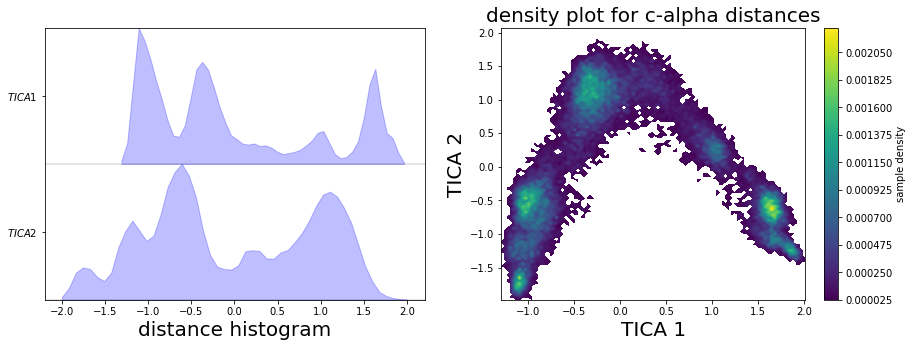

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
pyemma.plots.plot_feature_histograms(tics_ca_2D_conc, feature_labels=['$TICA 1$', '$TICA 2$'], ax=axes[0])
axes[0].set_xlabel('distance histogram', fontsize = 20.0)
pyemma.plots.plot_density(*tics_ca_2D_conc.T, ax=axes[1])
axes[1].set_title('density plot for c-alpha distances', fontsize = 20.0)
axes[1].set_xlabel('TICA 1', fontsize = 20.0)
axes[1].set_ylabel('TICA 2', fontsize = 20.0)

<Figure size 1080x360 with 0 Axes>

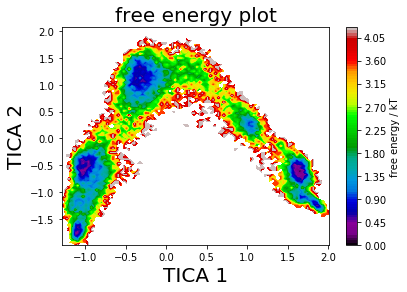

In [14]:
plt.figure(figsize=(15,5))
pyemma.plots.plot_free_energy(np.vstack(tics_ca_2D)[:,0], np.vstack(tics_ca_2D)[:,1])
plt.title('free energy plot', fontsize = 20.0)
plt.xlabel('TICA 1', fontsize = 20.0)
plt.ylabel('TICA 2', fontsize = 20.0)
plt.show()

## 4. Clustering- HDBscan 

In [15]:
data = tics_ca_2D_conc
data.shape

(29977, 2)

In [16]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=None).fit(data)

Text(0, 0.5, 'TIC 2')

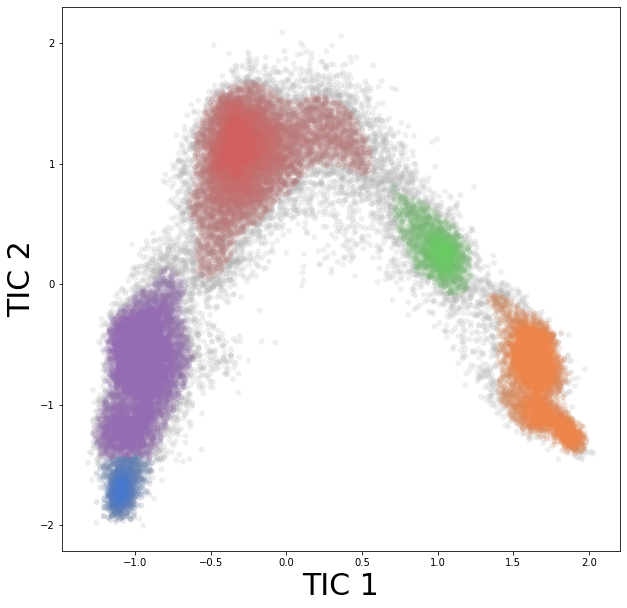

In [17]:
color_palette = sns.color_palette('muted', 7)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.7, 0.7, 0.7)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.figure(figsize=(10,10))
plt.scatter(*data.T, s=35, linewidth=0, c=cluster_member_colors, alpha=0.20)
plt.xlabel('TIC 1', fontsize=30)
plt.ylabel('TIC 2', fontsize=30)

In [18]:
dtraj_hdb_raw = clusterer.labels_
#Delete the noise
dtraj_hdb = dtraj_hdb_raw[dtraj_hdb_raw != -1]
print('not classified points:', len(dtraj_hdb_raw)-len(dtraj_hdb))

not classified points: 3035


In [19]:
its = pyemma.msm.timescales_msm(dtraj_hdb, lags=[1,10,20, 50], errors='bayes')
its2 = pyemma.msm.timescales_msm(dtraj_hdb, lags=[1,10, 50, 75, 100, 200], errors='bayes')
its3 = pyemma.msm.timescales_msm(dtraj_hdb, lags=[10, 200, 300, 400, 500], errors='bayes')
its4 = pyemma.msm.timescales_msm(dtraj_hdb, lags=[10, 500, 1000, 1500, 5000], errors='bayes')
its5 = pyemma.msm.timescales_msm(dtraj_hdb, lags=[10, 2500, 5000, 7500, 9500 ], errors='bayes')

Text(0.5, 1.0, 'from 0 to 9000 ns')

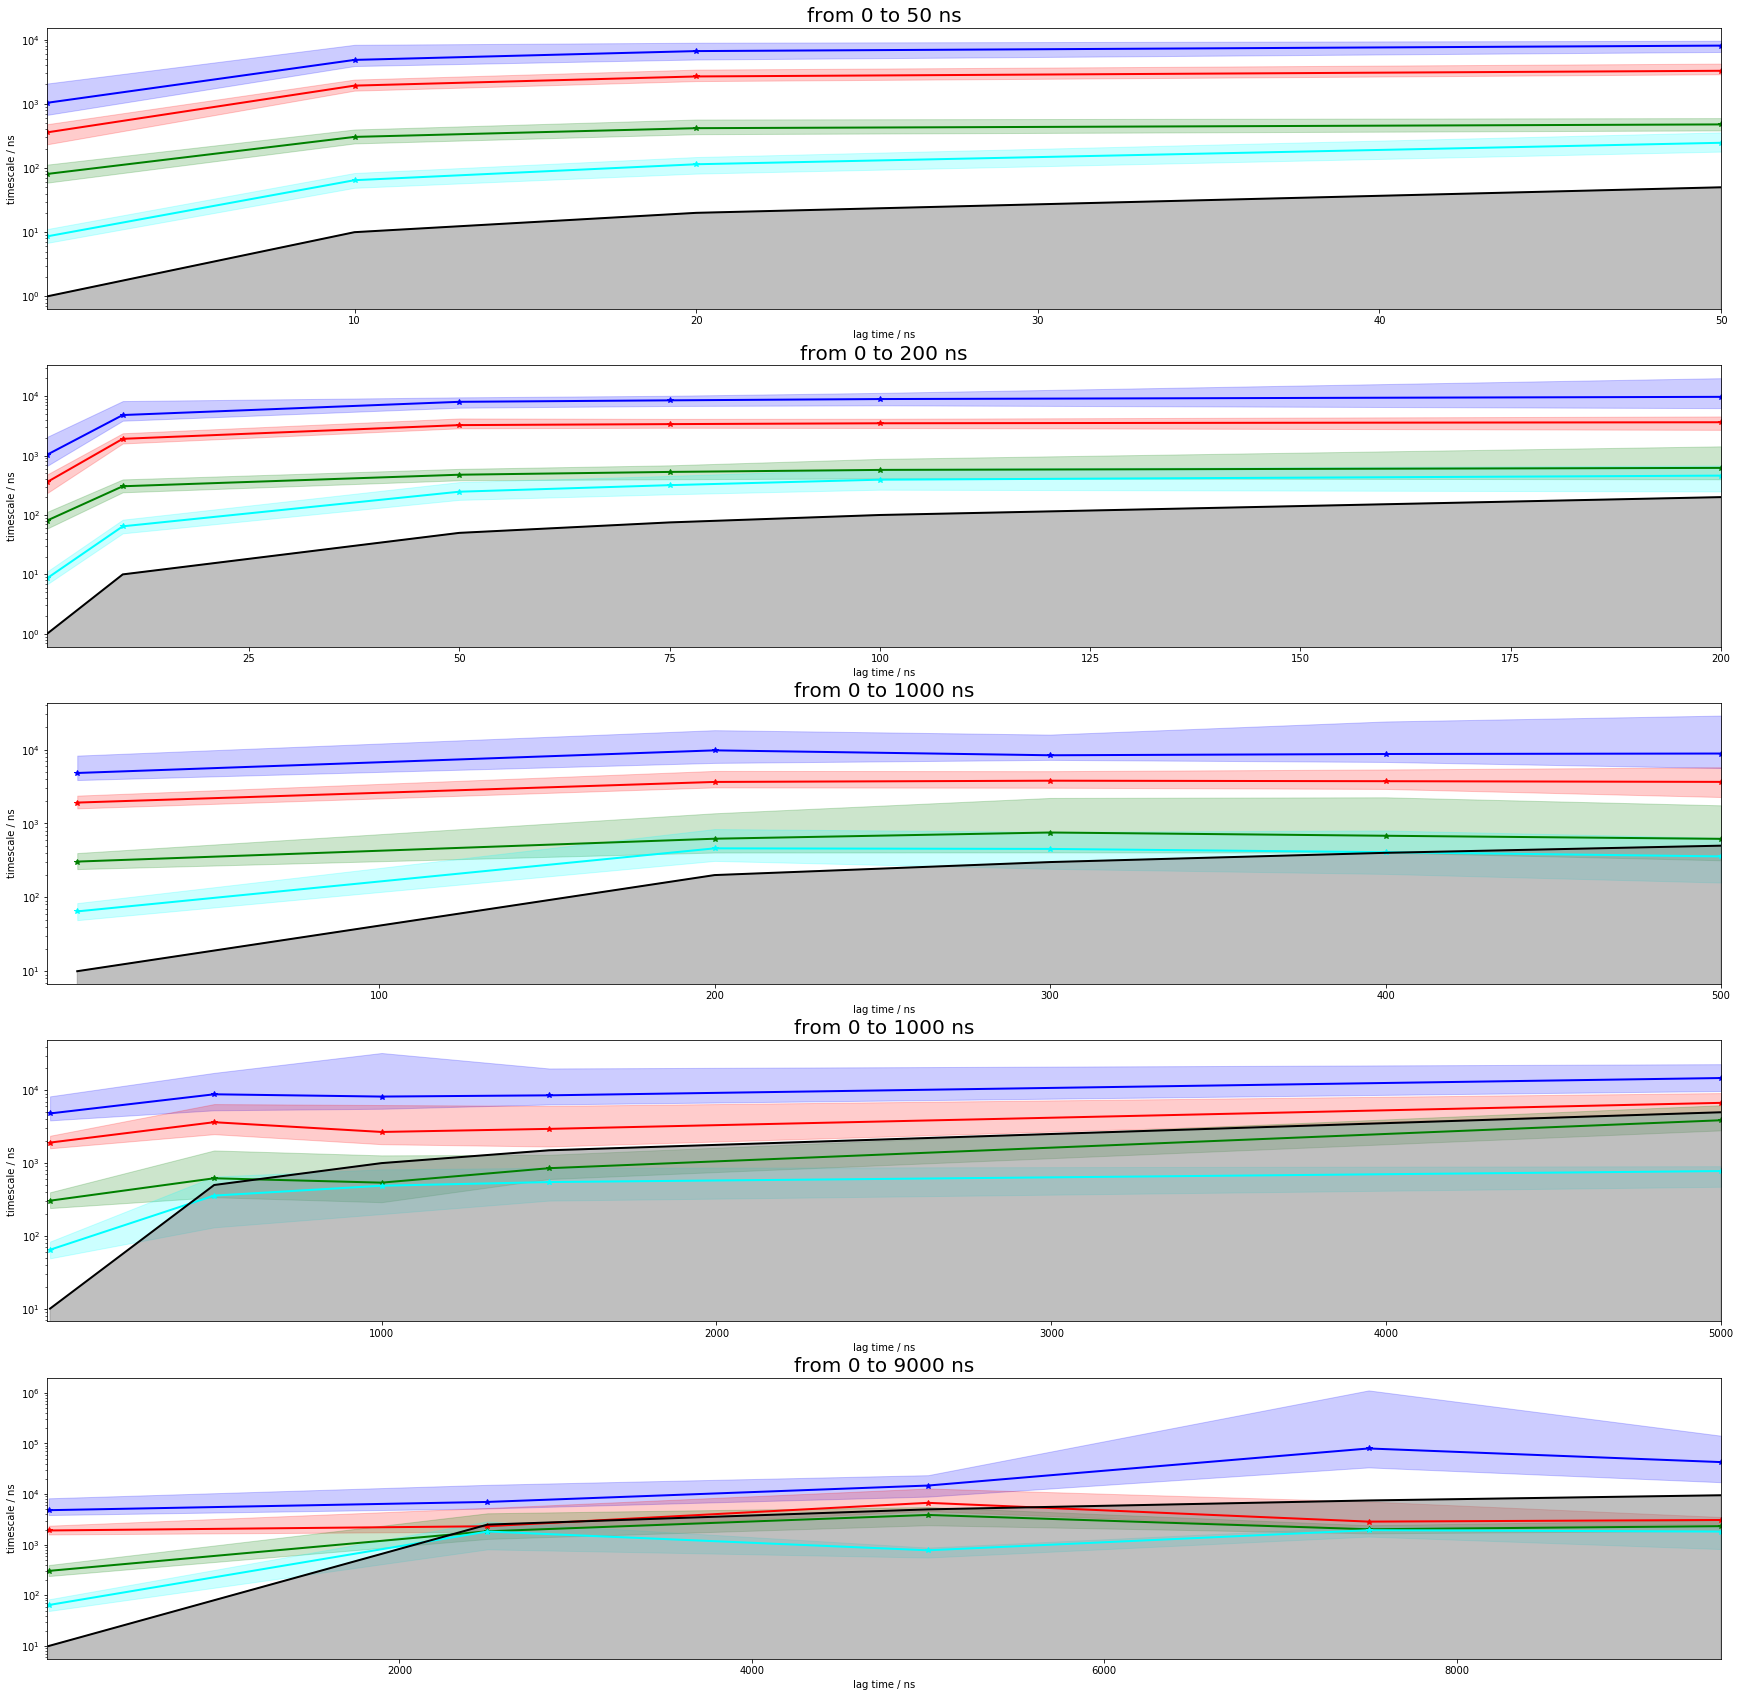

In [20]:
fig, ax = plt.subplots(5, 1, figsize=(30, 30))

mplt.plot_implied_timescales(its, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='*',nits=5,ax=ax[0])
ax[0].set_title('from 0 to 50 ns', fontsize=20)

mplt.plot_implied_timescales(its2, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='*',nits=5,ax=ax[1])
ax[1].set_title('from 0 to 200 ns', fontsize=20)

mplt.plot_implied_timescales(its3, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='*',nits=5,ax=ax[2])
ax[2].set_title('from 0 to 1000 ns', fontsize=20)

mplt.plot_implied_timescales(its4, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='*',nits=5,ax=ax[3])
ax[3].set_title('from 0 to 1000 ns', fontsize=20)

mplt.plot_implied_timescales(its5, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='*',nits=5,ax=ax[4])
ax[4].set_title('from 0 to 9000 ns', fontsize=20)

Text(0, 0.5, 'timescale/ns')

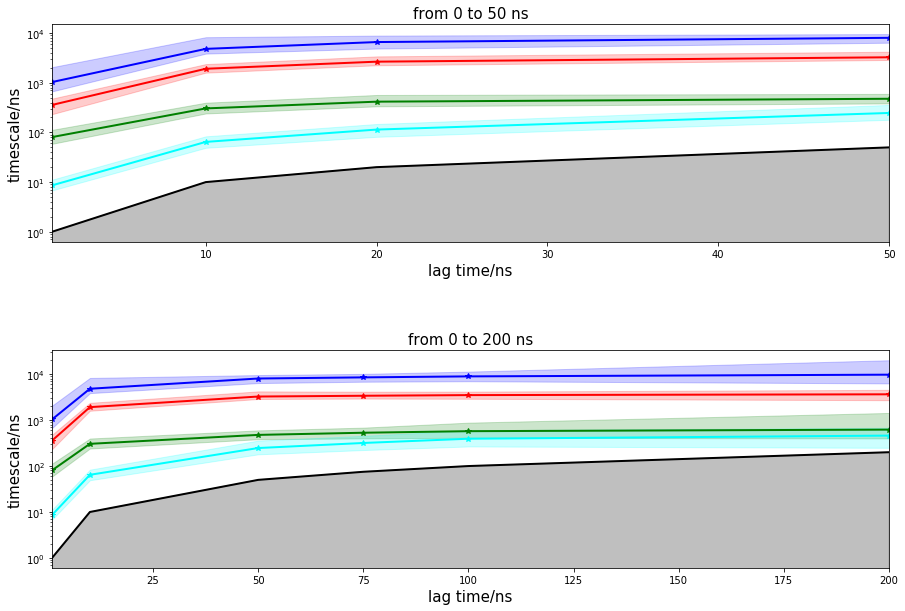

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

mplt.plot_implied_timescales(its, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='*',nits=5,ax=ax[0])
ax[0].set_title('from 0 to 50 ns', fontsize=15)
ax[0].set_xlabel('lag time/ns', fontsize = 15.0)
ax[0].set_ylabel('timescale/ns', fontsize = 15.0)

mplt.plot_implied_timescales(its2, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='*',nits=5,ax=ax[1])
ax[1].set_title('from 0 to 200 ns', fontsize=15)
ax[1].set_xlabel('lag time/ns', fontsize = 15.0)
ax[1].set_ylabel('timescale/ns', fontsize = 15.0)

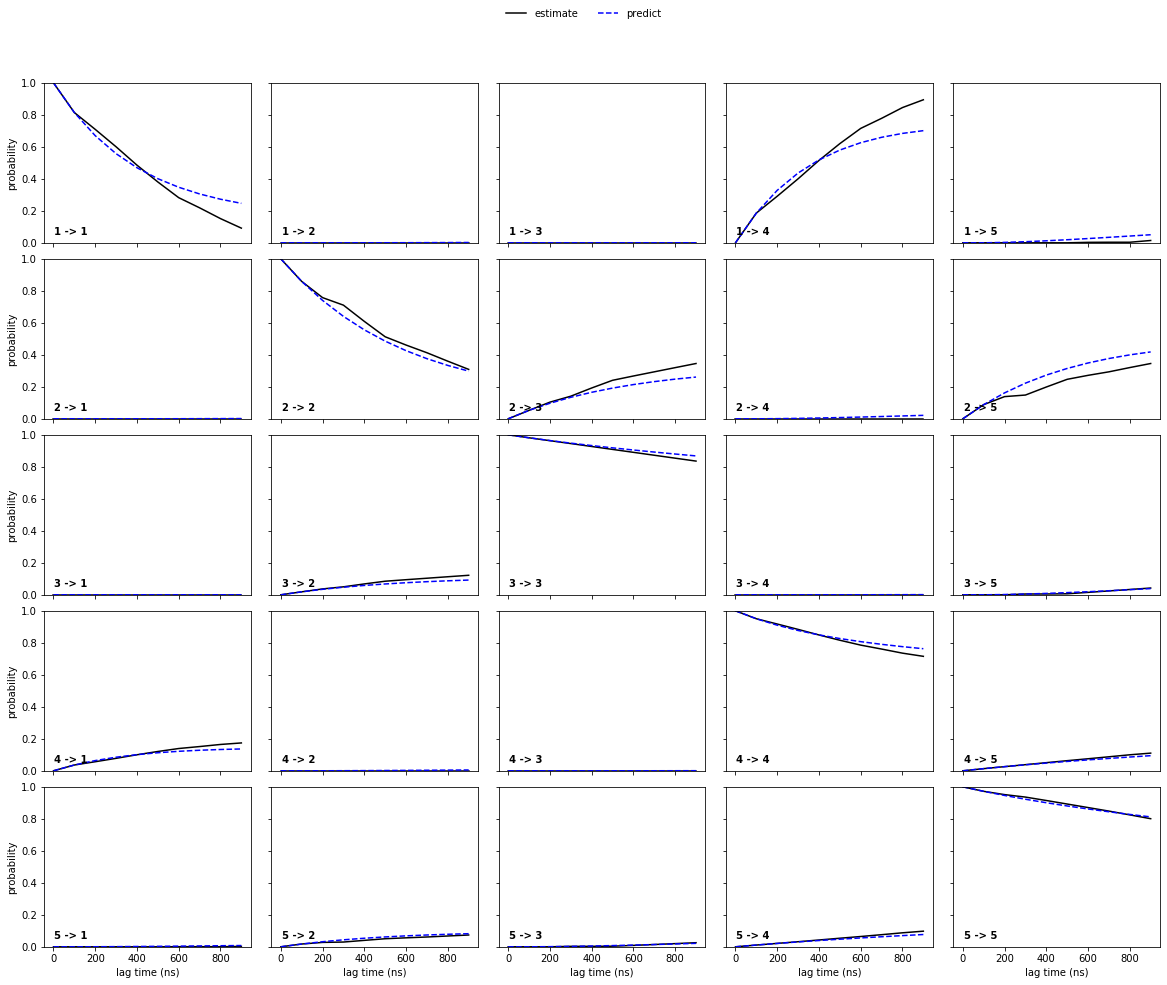

In [22]:
msm_lag100 = pyemma.msm.estimate_markov_model(dtraj_hdb, lag=100, dt_traj='1 ns')
pyemma.plots.plot_cktest(msm_lag100.cktest(5), units='ns', figsize=(20,15));

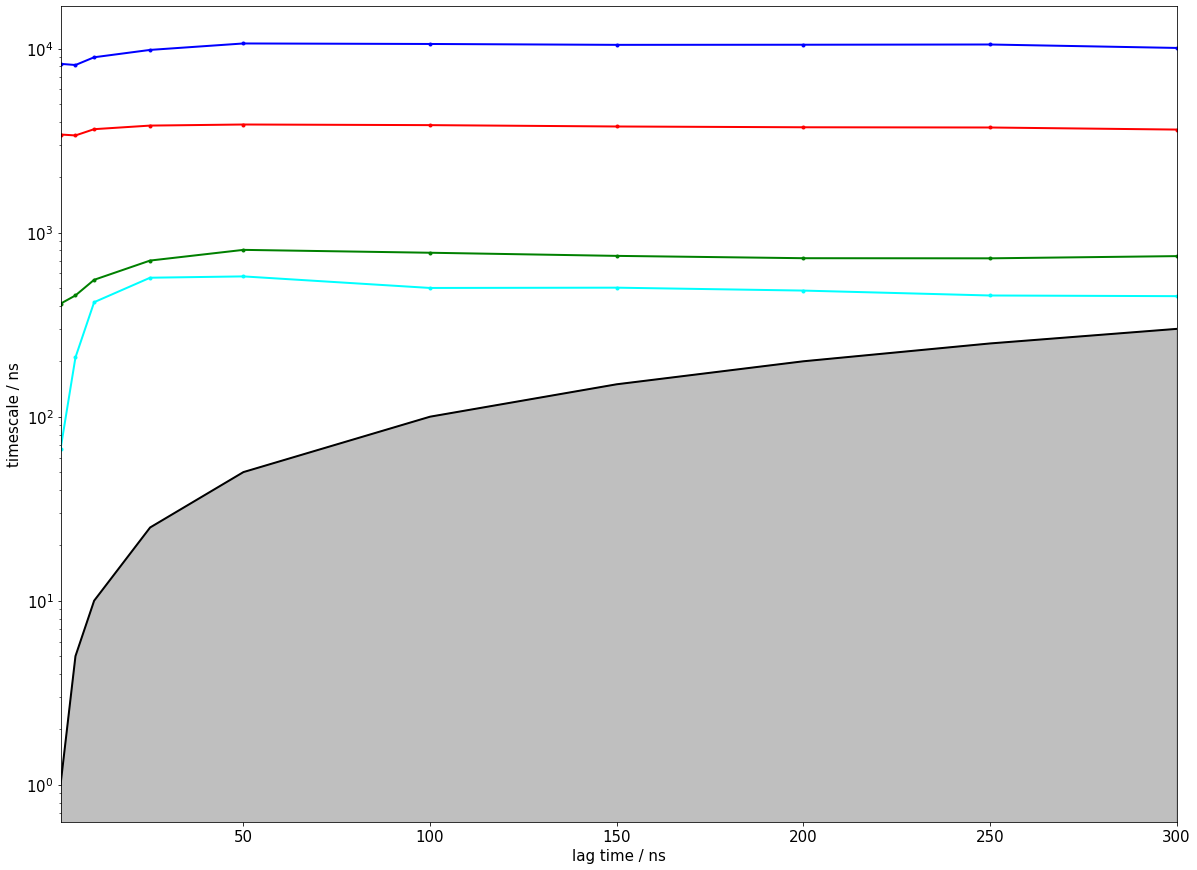

In [23]:
its_hmm = pyemma.msm.timescales_hmsm(dtraj_hdb, 5, lags=[1, 5, 10, 25, 50, 100, 150, 200, 250, 300])
plt.figure(figsize=(20,15))
matplotlib.rcParams.update({'font.size': 15})
mplt.plot_implied_timescales(its_hmm, show_mean=False, ylog=True, dt=1, units='ns', linewidth=2, marker='.')

In [24]:
hmm_5_NoC = pyemma.msm.estimate_hidden_markov_model(dtraj_hdb, 5, lag=50)

(<Figure size 2160x1440 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3b4ca0940>,
       dtype=object))

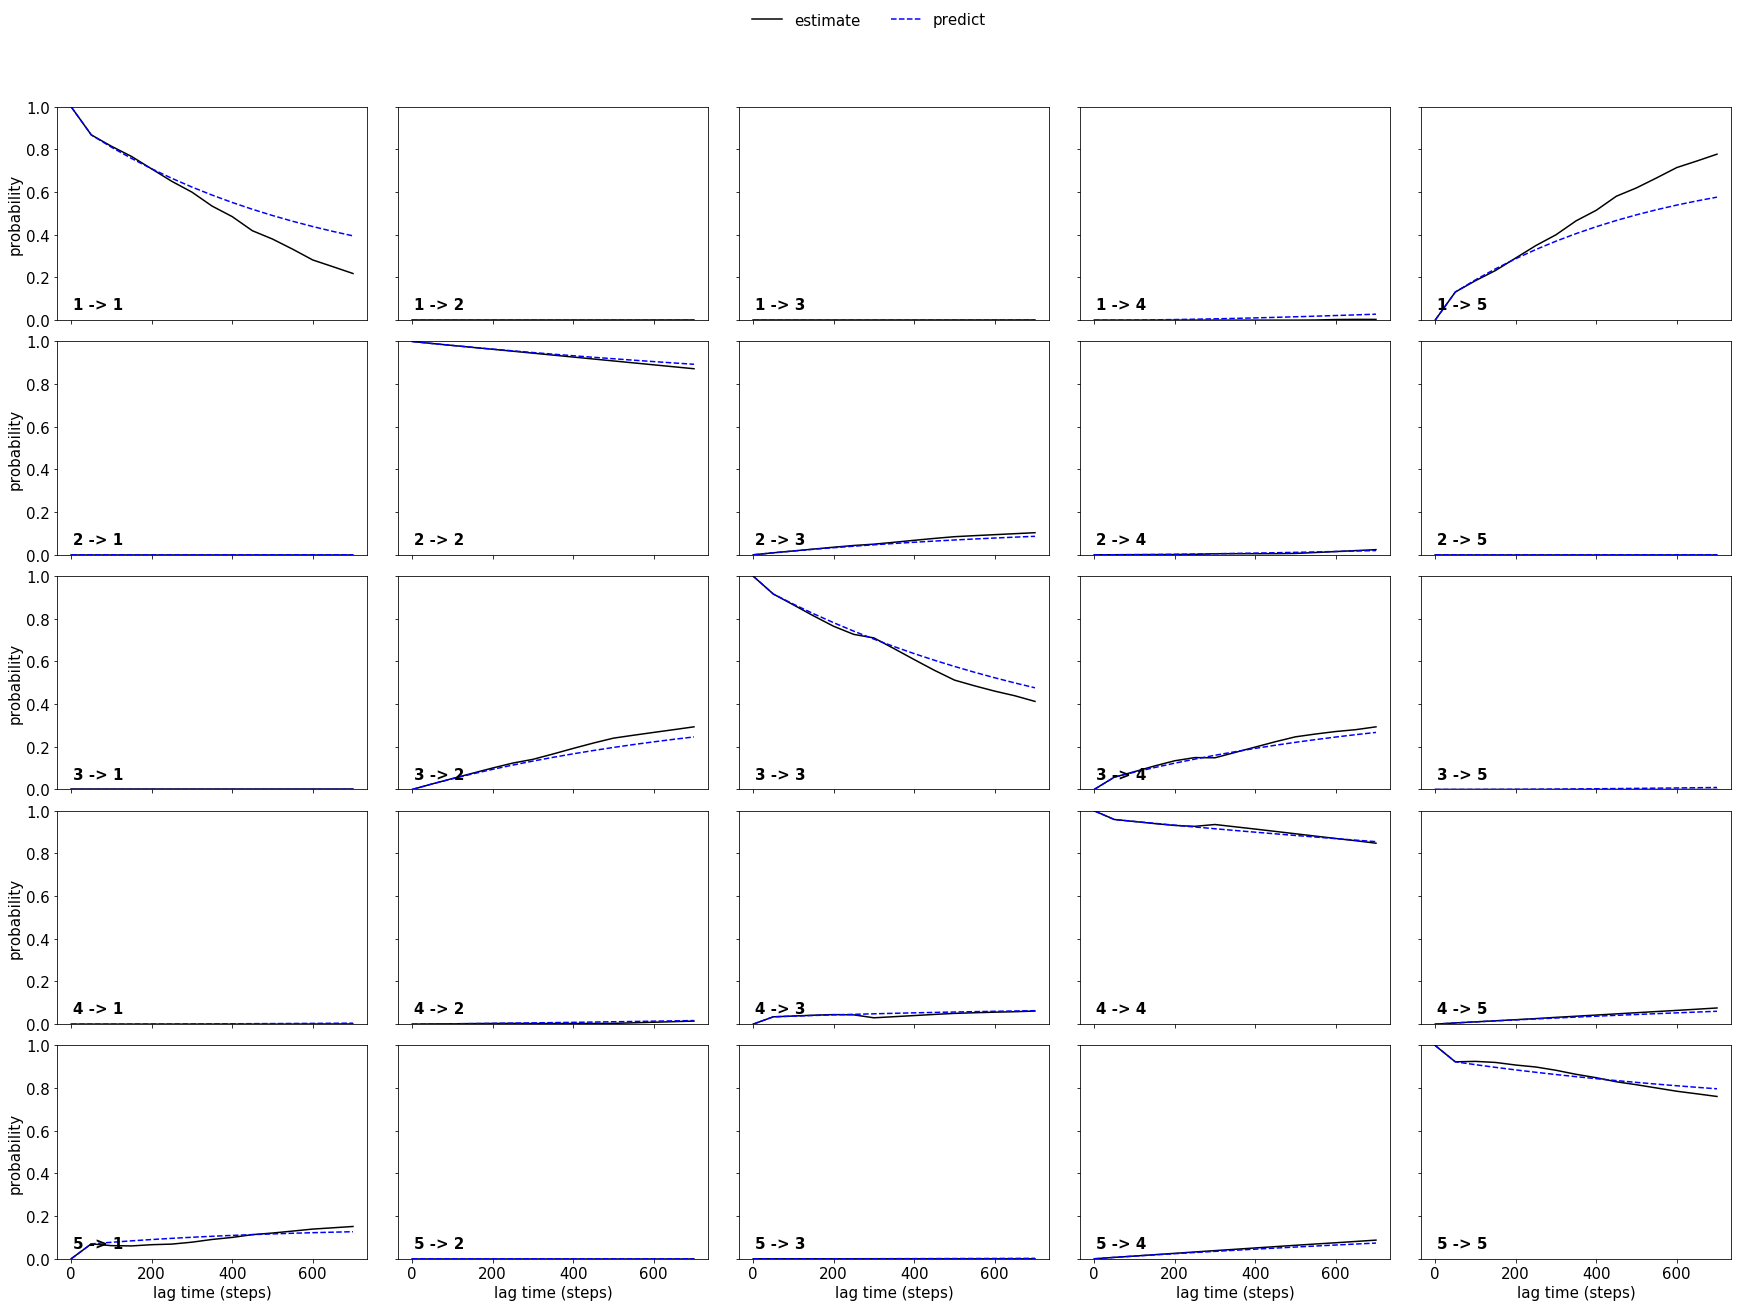

In [25]:
pyemma.plots.plot_cktest(hmm_5_NoC.cktest(mlags=15), figsize = (30,20))

In [26]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

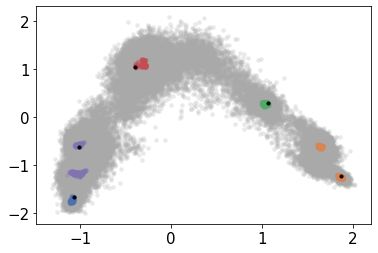

In [27]:
palette = sns.color_palette('deep', 5)
plot_kwds={'alpha':0.25, 's':20, 'linewidths':0}
tree2 = clusterer.condensed_tree_
plt.scatter(data.T[0], data.T[1], c='darkgrey', **plot_kwds)
for i, c in enumerate(tree2._select_clusters()):
    c_exemplars = exemplars(c, tree2)
    plt.scatter(data.T[0][c_exemplars], data.T[1][c_exemplars], c=palette[i], **plot_kwds)  
    plt.scatter(data.T[0][c_exemplars][:1], data.T[1][c_exemplars][:1], c='black', alpha=0.9, s=10)

In [28]:
def list_of_centers(tree, data):
    l = []
    r = []
    for i, c in enumerate(tree._select_clusters()):
        c_exemplars = exemplars(c, tree)
        #print(data.T[0][c_exemplars][:1],data.T[1][c_exemplars][:1])
        l.append(data.T[0][c_exemplars][:1][0])
        r.append(data.T[1][c_exemplars][:1][0])
        new_list = []
        for x,y in zip(l,r):
            new_list.append([x,y]) 
    return new_list

In [29]:
centers = list_of_centers(tree2,data)
print(centers)
pos = np.array(centers)

[[-1.0743886, -1.6681781], [1.8772554, -1.2240114], [1.0658072, 0.30004582], [-0.39721134, 1.0513283], [-1.0203437, -0.62223864]]


In [30]:
pos[1][0] +=-0.2
pos[1][1] += 0.4

In [31]:
metastable_traj = msm_lag100.metastable_assignments[dtraj_hdb]
highest_membership = msm_lag100.metastable_distributions.argmax(1)

In [32]:
np.unique(metastable_traj)

array([0, 1, 2, 3, 4])

In [33]:
tica0 = np.array([])
tica1 = np.array([])
for j in range(len(tics_ca_2D)):
    tica0 = np.concatenate((tica0, tics_ca_2D[j][:,0]))
for j in range(len(tics_ca_2D)):
    tica1 = np.concatenate((tica1, tics_ca_2D[j][:,1]))    
# histogram data
z,x,y = np.histogram2d(tica0, tica1, bins=200)
extent = (x.min(), x.max(), y.min(), y.max()) # extent of the plot
# compute free energies
F = -np.log(z)
F[F == 'inf' ] = -1000
maxval = np.amax(F)
F[F == -1000] = maxval
# plt.figure(figsize=(10,10))
# plt.contourf(F.T, 50, cmap= 'Oranges_r', extent = extent)
# plt.colorbar()
# plt.xlabel('TICA 1') 
# plt.ylabel('TICA 2')
# plt.show()

#del(tica0)
#del(tica1)

/home/argha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/argha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


## Markov State Model

Text(0, 0.5, 'TICA 2')

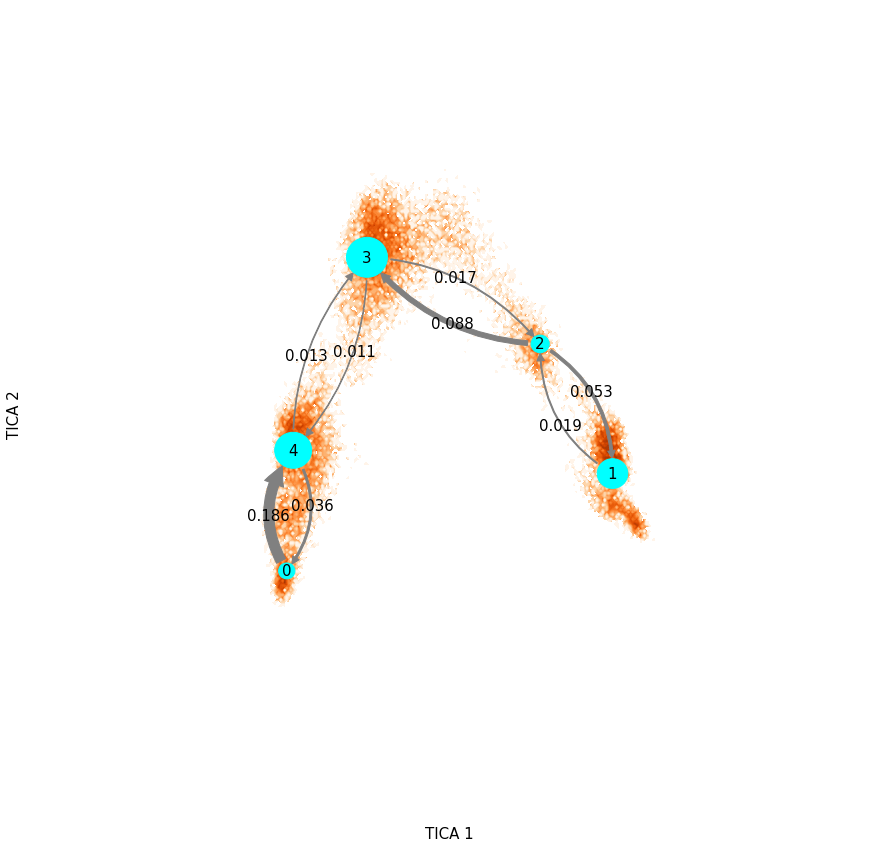

In [34]:
pyemma.plots.plot_markov_model(msm_lag100,pos=pos, minflux=1e-4, arrow_scale=1.5, arrow_label_format='%.3f', 
                               state_scale=0.1, state_colors='cyan', figpadding=0.8, max_width =30, max_height = 15)

plt.contourf(F.T, 50, cmap= 'Oranges_r', extent=extent, zorder=0)
plt.xlabel('TICA 1') 
plt.ylabel('TICA 2')

## Hidden Markov Model

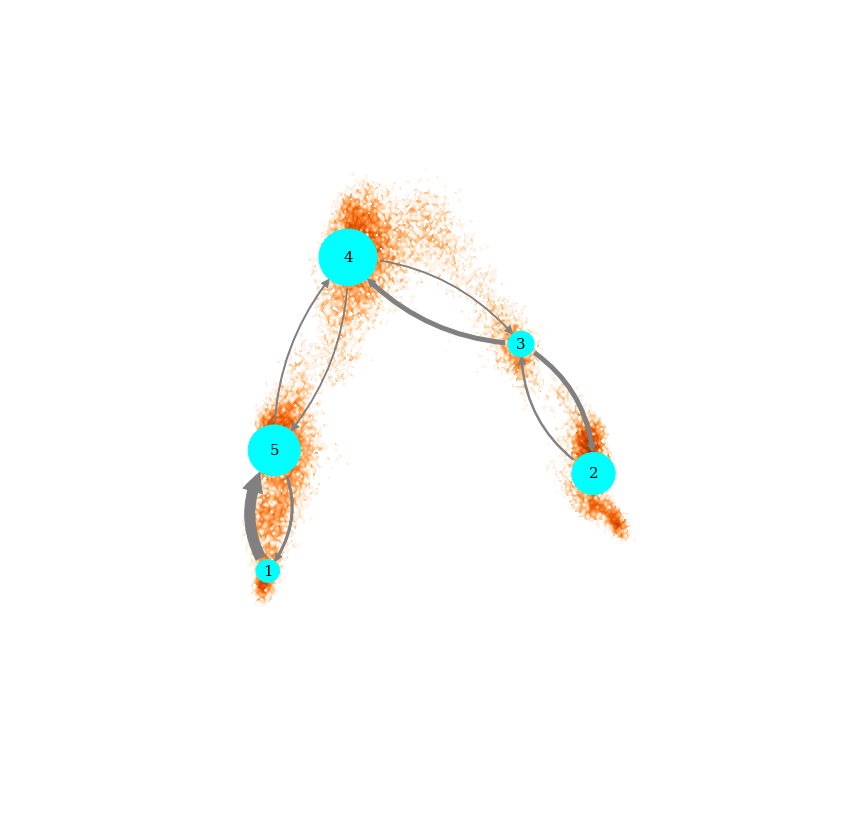

In [86]:
#plt.figure(figsize=(30,30))
pyemma.plots.plot_markov_model(hmm_5_NoC,pos=pos, minflux=1e-4, arrow_scale= 1.5, arrow_label_format='',
                               state_labels= [1,2,3,4,5],
                               state_scale=0.2, state_colors='cyan', figpadding=0.8
                               , max_width = 20, max_height = 15)

ax = plt.contourf(F.T, 50, cmap='Oranges_r', extent=extent, zorder=0)
#plt.xlabel('TICA 1') 
#plt.ylabel('TICA 2')

In [88]:
import pickle
with open('hmm_' + force_name + '.file', "wb") as f:
    pickle.dump([hmm_5_NoC,pos,F,extent], f, pickle.HIGHEST_PROTOCOL)

In [37]:
#ls

In [38]:
# with open('hmm_' + force_name + '.file', "rb") as f:
#     dump = pickle.load(f)


In [39]:
# pyemma.plots.plot_markov_model(dump[0],pos=dump[1], minflux=1e-4, arrow_scale= 1.5, arrow_label_format='', 
#                                state_scale=0.2, state_colors='cyan', figpadding=0.8
#                                , max_width = 20, max_height = 15)

# ax = plt.contourf(dump[2].T, 50, cmap='Oranges_r', extent=dump[3], zorder=0)

In [40]:
hmm_5_NoC.metastable_memberships

array([[9.68646841e-001, 0.00000000e+000, 5.53031255e-197,
        8.66841392e-066, 3.13531593e-002],
       [0.00000000e+000, 9.99995845e-001, 4.15472157e-006,
        2.64949594e-067, 8.92704057e-251],
       [2.88063681e-181, 8.93050670e-004, 9.93564135e-001,
        5.54281450e-003, 5.89671968e-064],
       [3.93869344e-035, 8.10180837e-059, 6.34715713e-003,
        9.93374628e-001, 2.78214908e-004],
       [1.27092871e-002, 1.74907241e-140, 3.79567825e-047,
        3.34818583e-004, 9.86955894e-001]])

In [41]:
metastable_traj

array([4, 4, 4, ..., 4, 4, 4])

In [42]:
bla = hmm_5_NoC.metastable_assignments[dtraj_hdb]

In [43]:
msm_lag100.metastable_assignments

array([0, 2, 1, 4, 3])

In [44]:
bla

array([3, 3, 3, ..., 3, 3, 3])

In [45]:
msm_lag100.metastable_assignments[dtraj_hdb].argmax(0)

0

/home/argha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/argha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


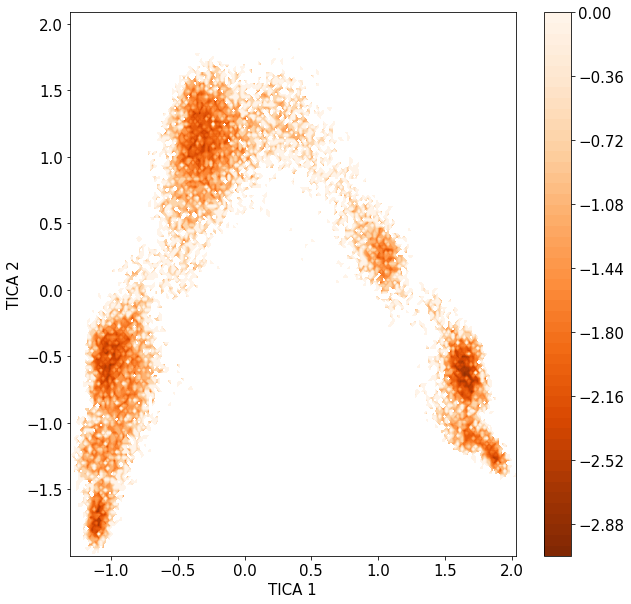

In [46]:
tica0 = np.array([])
tica1 = np.array([])
for j in range(len(tics_ca_2D)):
    tica0 = np.concatenate((tica0, tics_ca_2D[j][:,0]))
for j in range(len(tics_ca_2D)):
    tica1 = np.concatenate((tica1, tics_ca_2D[j][:,1]))    
# histogram data
z,x,y = np.histogram2d(tica0, tica1, bins=200)
extent = (x.min(), x.max(), y.min(), y.max()) # extent of the plot
# compute free energies
F = -np.log(z)
F[F == 'inf' ] = -1000
maxval = np.amax(F)
F[F == -1000] = maxval
plt.figure(figsize=(10,10))
plt.contourf(F.T, 50, cmap= 'Oranges_r', extent = extent)
plt.colorbar()
plt.xlabel('TICA 1') 
plt.ylabel('TICA 2')
plt.show()

#del(tica0)
#del(tica1)

In [47]:
tics_ca_2D_conc[3049]

array([-0.700771  , -0.02214338], dtype=float32)

In [48]:
bla

array([3, 3, 3, ..., 3, 3, 3])

In [49]:
np.where(bla == 4)

(array([ 2741,  2776,  2791, ..., 14626, 14627, 14628]),)

In [50]:
np.where(dtraj_hdb_raw == -1)

(array([   12,    13,    23, ..., 29952, 29955, 29970]),)

In [51]:
# import MDAnalysis as mdana
# from MDAnalysis.analysis.distances import distance_array

In [52]:
# uni = mdana.Universe('ab40-desres.pdb','traj_concatenated.dcd')

In [53]:
# n,t = list(enumerate(uni.trajectory))[0]
# box = t.dimensions[:6]

In [54]:
# np.where(dtraj_hdb_raw == -1)[0]

In [55]:
import mdtraj as md

In [56]:
traj = md.load('traj_concatenated.dcd', top = 'ab40-desres.pdb')
print('Total number of frames :',len(traj))

Total number of frames : 29977


In [57]:
topology = traj.topology
back = topology.select("all") #select all atoms

In [58]:
NATIVE_CUTOFF = 0.4  # cut off distance for contact

In [59]:
hmm_num_states = len(hmm_5_NoC.metastable_assignments)
contact_matrix = np.zeros((hmm_num_states, 40, 40))

In [60]:
pair_list = []
for i in back:
    for j in back:
        if (j != i):       
            pair_list.append([i, j])
atom_pair = np.array(pair_list)

In [61]:
# dtraj_hmm = hmm_5_NoC.metastable_assignments[dtraj_hdb]
# index1 = -1 
# #to find position in dtaj_hmm as it's indexes are different from dtraj_hdb_new or uni.trajectory
# for index in range(0, len(traj)-1):
#     if index not in np.where(dtraj_hdb_raw == -1)[0]:
#         print(index)
#         index1 = index1 + 1;
#         cmatrix_index1 = dtraj_hmm[index1]
#         distances = md.compute_distances(traj[index], atom_pair, periodic=True, opt=True)[0]
#         # sub-matrix of atom_pair containing only contact pairs defined by a cut off distance
#         bla = list(np.nonzero(distances <= NATIVE_CUTOFF))
#         #contact_pairs = atom_pair[distances < NATIVE_CUTOFF]
#         contact_pairs = [atom_pair[ii] for ii in bla[0]]
#         contact_pairs = np.array(contact_pairs)
#         # populating the contact_matrix -> c_matrix
#         for i in range(0,len(contact_pairs[:])):
#             x = topology.atom(contact_pairs[i][0]).residue.index
#             y = topology.atom(contact_pairs[i][1]).residue.index
#             contact_matrix[cmatrix_index1][x][y] = contact_matrix[cmatrix_index1][x][y] + 1

In [3]:
save_dir  = '/home/argha/RWTH/HiWi/HiWi_Prof_strodel/jupyter_work/Codes_Paper/Plot_3_contact/Plots/'
forcename = 'a99SBdisp'
#np.save(save_dir + 'full_contact_' + forcename + '.npy',contact_matrix)

In [63]:
# c_matrix=contact_matrix/np.max(contact_matrix)  #normalized matrix
# # normalizing
# for i in range(hmm_num_states):
#     c_matrix[i]=contact_matrix[i]/np.max(contact_matrix[i])
    
# ## set tri-diagonal elements to zero to highlight other contacts
# for k in range(hmm_num_states):
#     for i in range(40):
#             c_matrix[k][i][i] = 0
#             if i != 0:
#                 c_matrix[k][i][i-1] = 0
#             if i != 39:
#                 c_matrix[k][i][i+1] = 0               
# #normalizing
# for i in range(hmm_num_states):
#     c_matrix[i]=c_matrix[i]/np.max(c_matrix[i])

In [4]:
c_matrix = np.load(save_dir + 'normalized_contact_' + forcename + '.npy')
#np.save(save_dir + 'normalized_contact_' + forcename + '.npy',c_matrix)

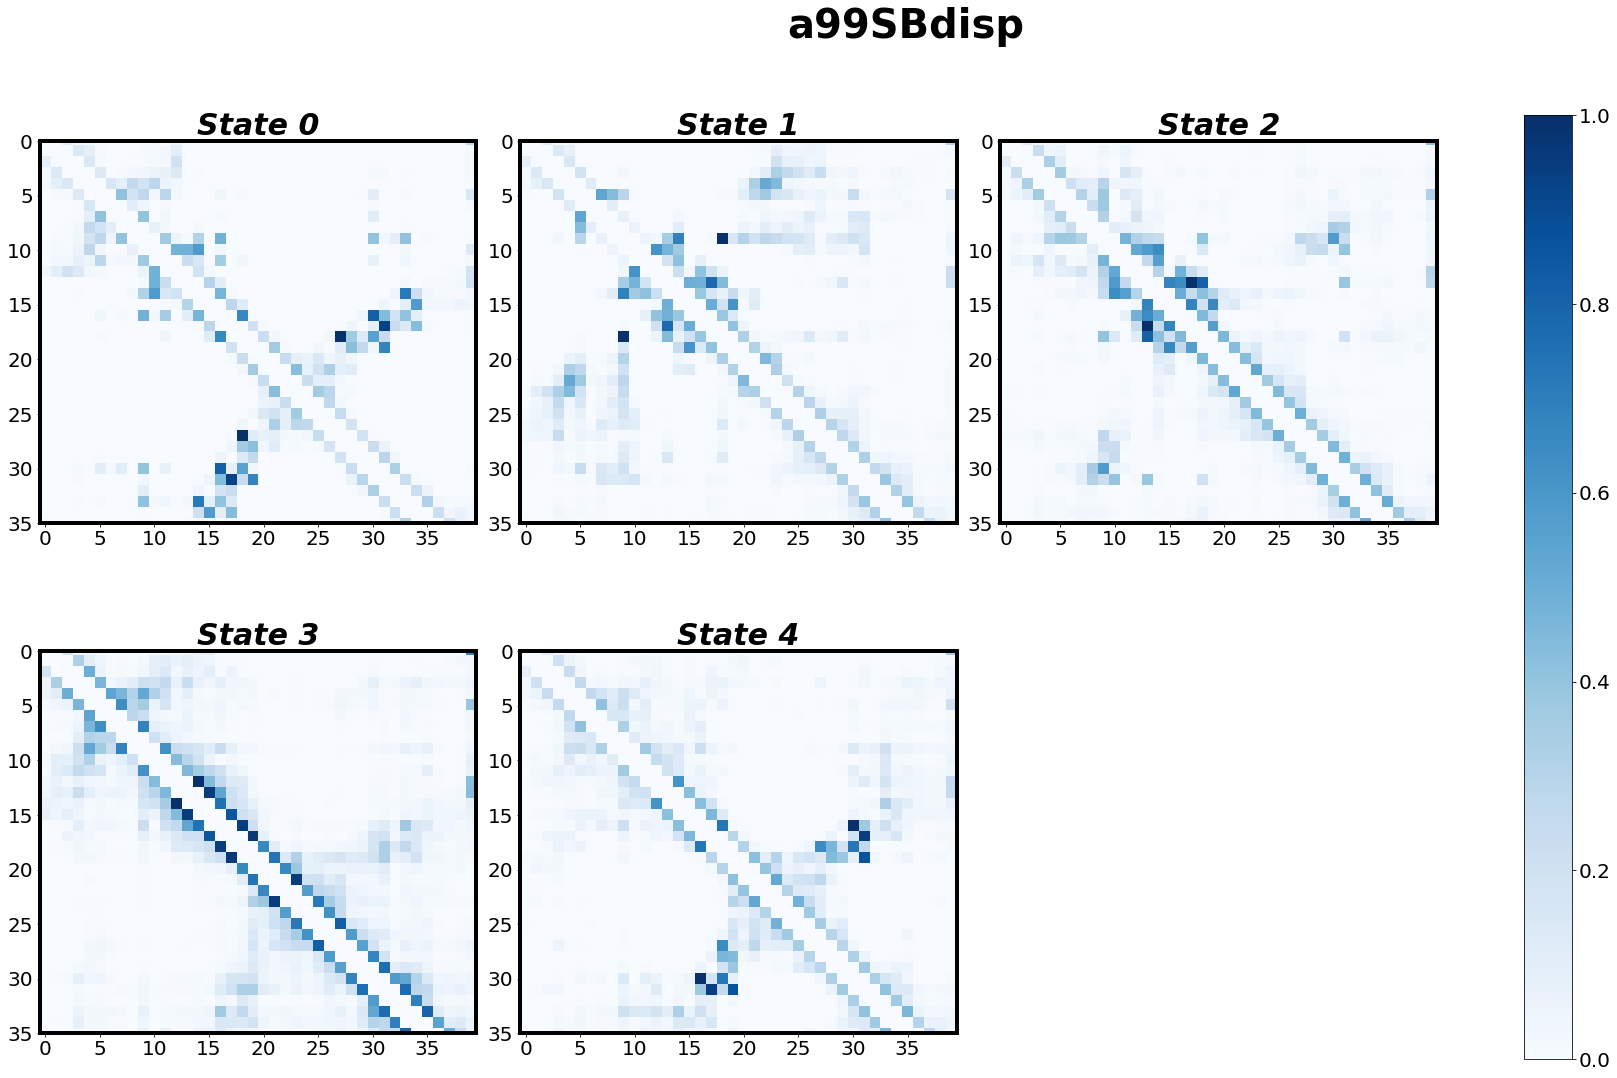

In [5]:
hmm_num_states = 5

fig, ax = plt.subplots(hmm_num_states,figsize=(50, 15))
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle(forcename, fontsize = 40, weight = 'bold', x=0.25, y = 1)
#specifying the grid layout
shape = (2,6)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

for j in range(0,hmm_num_states):
    #specifying position of ax[j] in the plot using (row,col)
    row = 0 if j<3 else 1
    col = j % 3
    
    ax[j] = plt.subplot2grid(shape,(row,col))
    im = ax[j].imshow(c_matrix[j], cmap='Blues', interpolation='nearest')
    ax[j].set_title('State ' + str(j), fontsize = 30, weight = 'bold', fontstyle = 'italic')
    for axis in ['top','bottom','left','right']:
        ax[j].spines[axis].set_linewidth(4)
        
    ax[j].set_xticks(np.arange(0, 40, step=5))
    ax[j].set_yticks(np.arange(0, 40, step=5))
    
fig.colorbar(im, ax=ax.ravel().tolist())

#plt.savefig(save_dir + forcename +'.png', bbox_inches='tight', quality=200, dpi=400)  

In [ ]:
#np.save(save_dir + 'contact_a99SBdisp.npy',c_matrix)

In [70]:
hmm_5_NoC.metastable_assignments

array([0, 1, 2, 3, 4])

In [71]:
dtraj_hmm = hmm_5_NoC.metastable_assignments[dtraj_hdb]

In [72]:
import collections

In [73]:
collections.Counter(dtraj_hmm)

Counter({3: 9963, 4: 8009, 0: 1560, 2: 1933, 1: 5477})

In [74]:
collections.Counter(dtraj_hdb)

Counter({3: 9963, 4: 8009, 0: 1560, 2: 1933, 1: 5477})

In [6]:
class plot_parameters:
    def __init__(self, fig_width, fig_height, columns):
        assert(columns in [1,2])
        if fig_width is None:
            self.fig_width =  3.42 if columns==1 else 7 # width in inches
        else:
            self.fig_width = fig_width
            
        if fig_height is None:
            #golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
            #self.fig_height = self.fig_width*golden_mean # height in inches
            self.fig_height = self.fig_width/2.5 # height in inches
        else:
            self.fig_height = fig_height
            
        MAX_HEIGHT_INCHES = 9.0
        if self.fig_height > MAX_HEIGHT_INCHES:
            print("WARNING: fig_height too large:" + str(self.fig_height) + 
                  "so will reduce to" + str(MAX_HEIGHT_INCHES) + "inches.")
            self.fig_height = MAX_HEIGHT_INCHES
            
        print(str (self.fig_height * 2.54) + ' cm')
            
        self.params = {'backend': 'ps',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              #'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'}
        '''
        self.font_size = 20
        self.ticklabelsize = 15
        self.axislabelsize = 15
        self.titlesize = 20
        self.font_type = 'serif'
        self.wspace = 0.25
        self.hspace = 0.45
        self.patchlinewidth = 1.5
        self.plotlinewidth = 6
        '''
        
        self.font_size = 4
        self.ticklabelsize = 4
        self.axislabelsize = 4
        self.titlesize = 4
        self.font_type = 'serif'
        self.wspace = 0.1
        self.hspace = 0.25
        self.patchlinewidth = 0.5
        self.plotlinewidth = 1.5
            

7.111999999999999 cm


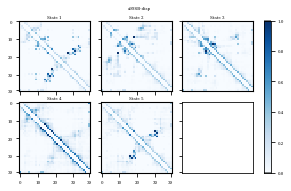

In [8]:
forcename = 'a99SB-disp'
from mpl_toolkits.axes_grid1 import AxesGrid

plot1 = plot_parameters(None, None, 2)
plt.rc('font', family= plot1.font_type)


fig = plt.figure(figsize=(plot1.fig_width,plot1.fig_height))
fig.suptitle(forcename, fontsize = plot1.font_size, y= 0.95)

grid = AxesGrid(fig,111,
                nrows_ncols=(2, 3),
                axes_pad=0.15,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.15
                )
j = 0
for ax in grid:
    #ax.set_axis_off()
    #major_ticks = [0,10,20,30,39+1]
    
    #ax.xaxis.set_major_locator(plt.FixedLocator(major_ticks))
    #ax.set_xticks(major_ticks)
    
    #ax.set_xticks(np.arange(0, 41, step=5))
    #ax.set_yticks(np.arange(0, 41, step=5))
    ax.set_xticks([])
    #ax.set_yticks([])
    if j < 5:
        ax.set_xticks([0,10,20,30,39])
        ax.set_yticks([0,10,20,30,39])
        ax.tick_params(axis='both', which='major', labelsize= plot1.axislabelsize)
        ax.set_title('State ' + str(j+1), fontsize = plot1.font_size, y= 0.95)
        im = ax.imshow(c_matrix[j],cmap = 'Blues',interpolation='nearest')
        j = j+1
        
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.1)
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)
cbar.ax.tick_params(labelsize= plot1.axislabelsize) 
#plt.savefig(save_dir + force_name +'.pdf', bbox_inches='tight', quality=200, dpi=400)

In [ ]:
save_dir1  = '/home/argha/RWTH/HiWi/HiWi_Prof_strodel/jupyter_work/Codes_Paper/Plot_3_contact/Plots_1905/'

forcename = 'C22*/TIP3P'

from mpl_toolkits.axes_grid1 import AxesGrid

plot1 = plot_parameters(None, None, 2)
plt.rc('font', family= plot1.font_type)


fig = plt.figure(figsize=(plot1.fig_width,plot1.fig_height))
fig.suptitle(forcename, fontsize = plot1.font_size, y= 0.95)

grid = AxesGrid(fig,111,
                nrows_ncols=(2, 3),
                axes_pad=0.15,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.15
                )
j = 0
for ax in grid:
    #ax.set_axis_off()
    #major_ticks = [0,10,20,30,39+1]
    
    #ax.xaxis.set_major_locator(plt.FixedLocator(major_ticks))
    #ax.set_xticks(major_ticks)
    
    #ax.set_xticks(np.arange(0, 41, step=5))
    #ax.set_yticks(np.arange(0, 41, step=5))
    ax.set_xticks([])
    #ax.set_yticks([])
    if j < 5:
        ticksPositions = [0,9,19,29,39]
        sequence = [1,10,20,30,40]
        ax.set_xticks(ticksPositions)
        ax.set_yticks(ticksPositions)
        ax.set_xticklabels(sequence)
        ax.set_yticklabels(sequence)
        
        ax.tick_params(axis='both', which='major', labelsize= plot1.axislabelsize)
        ax.set_title('State ' + str(j+1), fontsize = plot1.font_size, y= 0.95)
        im = ax.imshow(c_matrix[j],cmap = 'Blues',interpolation='nearest')
        j = j+1
        
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.1)
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)
cbar.ax.tick_params(labelsize= plot1.axislabelsize) 
plt.savefig(save_dir1 + force_name +'.pdf', bbox_inches='tight', quality=200, dpi=400)